# 05 — Night Time Light

**Goal:** download monthly VIIRS DNB composites for Sundarbans bbox analysis.

We download TWO GeoTIFFs per month:
- *.avg_rade9h.tif  = radiance (brightness signal)
- *.cf_cvg.tif      = cloud-free coverage / observation count (quality)

**Tile:** 75N060E (covers lon 60–180, lat 0–75). Sundarbans bbox is a tiny window inside this tile.

**Important:** do NOT judge data quality from a full-tile “quick view”. Always clip to bbox first.

**Note:** June monthly VIIRS DNB composites can show large high-latitude ‘blackouts’ because the compositing pipeline excludes sunlit/twilight-contaminated observations near the summer solstice; in those regions the monthly average radiance may be recorded as zeros. Use cf_cvg to interpret whether zeros reflect lack of valid observations.

**Purpose:** Load the geospatial + raster tooling we will use throughout this notebook.
We will work with VIIRS Nighttime Lights (NTL) monthly composites in GeoTIFF format using rasterio, and we will later overlay vector coastlines/islands using geopandas.

In [20]:
import rasterio
import numpy as np
from pathlib import Path

## June 2018 Data

We start with June 2018 as a working month to validate the pipeline end-to-end (paths → sanity checks → visualization → features).

**Input files (June 2018):**

- avg_rade9h = average radiance (the “night lights” intensity)
- cf_cvg = coverage / observation count-type layer used as a reliability mask

In [21]:
rad_path = "../data/ntl/raw/201806/SVDNB_npp_20180601-20180630_75N060E_vcmcfg_v10_c201904251200.avg_rade9h.tif"
cvg_path = "../data/ntl/raw/201806/SVDNB_npp_20180601-20180630_75N060E_vcmcfg_v10_c201904251200.cf_cvg.tif"

**Guardrail sanity check (CRS, bounds, and a known point)**

This helper prints CRS, bounds, resolution, array shape, and optionally samples a known lon/lat point (near Sundarbans) to confirm the raster is:

in EPSG:4326, and

actually contains our region of interest.

This is the “don’t-trust-the-plot-yet” check that prevents false conclusions.

In [22]:
def raster_guardrail(raster_path, target_lon=None, target_lat=None, name="raster"):
    with rasterio.open(raster_path) as src:
        print(f"\n[{name}] {raster_path}")
        print("CRS:", src.crs)
        print("Bounds:", src.bounds)
        print("Res:", src.res)
        print("Shape:", (src.height, src.width))
        print("NoData:", src.nodata)

        if target_lon is not None and target_lat is not None:
            if not (src.bounds.left <= target_lon <= src.bounds.right and
                    src.bounds.bottom <= target_lat <= src.bounds.top):
                raise ValueError(f"Target point ({target_lon}, {target_lat}) is OUTSIDE bounds.")
            r, c = src.index(target_lon, target_lat)
            val = src.read(1, window=((r, r+1), (c, c+1)))[0, 0]
            print(f"Target point -> row,col=({r},{c}), value={val}")

# Example: Sundarbans-ish point
raster_guardrail(str(rad_path), target_lon=88.9, target_lat=22.0, name="VIIRS radiance")
raster_guardrail(str(cvg_path), target_lon=88.9, target_lat=22.0, name="VIIRS coverage")



[VIIRS radiance] ../data/ntl/raw/201806/SVDNB_npp_20180601-20180630_75N060E_vcmcfg_v10_c201904251200.avg_rade9h.tif
CRS: EPSG:4326
Bounds: BoundingBox(left=59.99791666665, bottom=0.0020827333499937595, right=179.99791762665, top=75.00208333335)
Res: (0.0041666667, 0.0041666667)
Shape: (18000, 28800)
NoData: None
Target point -> row,col=(12720,6936), value=0.44999998807907104

[VIIRS coverage] ../data/ntl/raw/201806/SVDNB_npp_20180601-20180630_75N060E_vcmcfg_v10_c201904251200.cf_cvg.tif
CRS: EPSG:4326
Bounds: BoundingBox(left=59.99791666665, bottom=0.0020827333499937595, right=179.99791762665, top=75.00208333335)
Res: (0.0041666667, 0.0041666667)
Shape: (18000, 28800)
NoData: None
Target point -> row,col=(12720,6936), value=3


**Quick visual smoke test (downsampled)**

This is a fast sanity plot (heavily downsampled) just to confirm the raster has structure and is not empty/corrupt—not for interpretation.

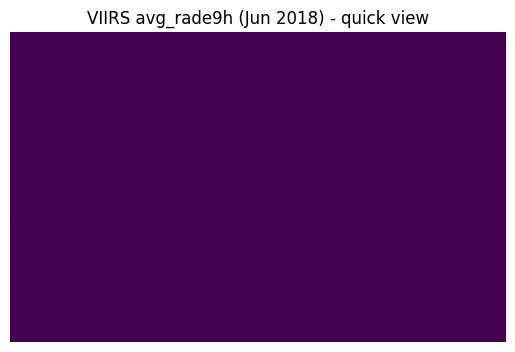

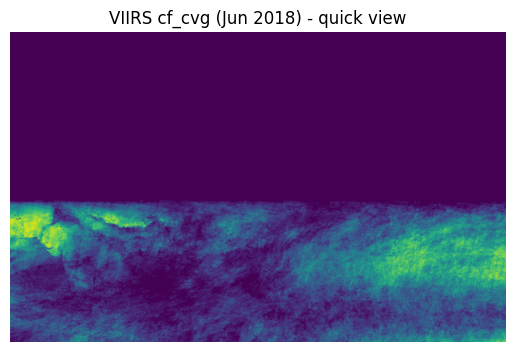

In [23]:
import matplotlib.pyplot as plt

def show_quick(path, title):
    with rasterio.open(path) as src:
        arr = src.read(1)
        # simple downsample to avoid huge plots
        arr_small = arr[::10, ::10]

    plt.figure()
    plt.imshow(arr_small)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_quick(rad_path, "VIIRS avg_rade9h (Jun 2018) - quick view")
show_quick(cvg_path, "VIIRS cf_cvg (Jun 2018) - quick view")


**First-pass radiance visibility: mask low coverage, then log-scale**

Mask pixels where coverage is low (cvg < 2) to avoid interpreting unreliable values.

Apply log10(radiance) because VIIRS radiance is highly skewed (a few bright areas dominate).

Note: warnings like “invalid value encountered in log10” typically happen when there are NaNs (from masking) or zeros—expected in this workflow.

/var/folders/53/ps9kkpj52j71m9fx4fmfqxsw0000gn/T/ipykernel_73310/2234528590.py:13: RuntimeWarning: invalid value encountered in log10
  rad_log = np.log10(rad + 1e-6)


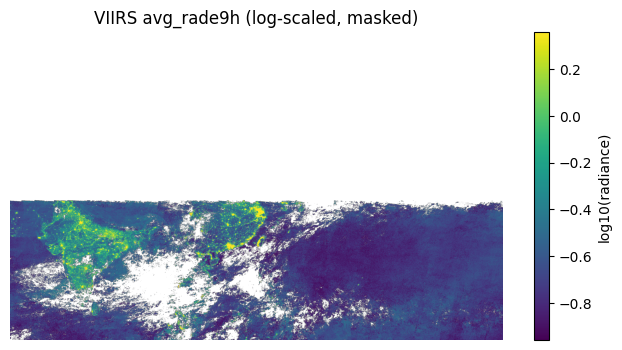

In [24]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

with rasterio.open(rad_path) as rsrc, rasterio.open(cvg_path) as csrc:
    rad = rsrc.read(1).astype("float64")
    cvg = csrc.read(1).astype("float64")

# Mask low observation coverage (tunable)
rad[cvg < 2] = np.nan

# Log transform for visibility
rad_log = np.log10(rad + 1e-6)

# Percentile stretch (ignore extreme outliers)
vmin, vmax = np.nanpercentile(rad_log, [5, 99])

plt.figure(figsize=(8, 4))
plt.imshow(rad_log[::10, ::10], vmin=vmin, vmax=vmax)
plt.title("VIIRS avg_rade9h (log-scaled, masked)")
plt.colorbar(label="log10(radiance)")
plt.axis("off")
plt.show()


**Define our Sundarbans-focused bounding box (lon/lat)**

This bbox is the “lens” we use for:

- clipping the raster window,

- producing comparable plots,

- extracting consistent monthly features.

In [25]:
bbox = {"lon_min": 88.0, "lat_min": 21.3, "lon_max": 89.3, "lat_max": 22.6}

**Tile-scale context view (downsampled) + bbox overlay**

Before zooming in, we plot a coarse preview of the entire VIIRS tile and draw the bbox rectangle on top.

This is a key guardrail: if the bbox is drawn in the wrong place (or axes look wrong), we fix that before doing any “region-level” interpretation.

/var/folders/53/ps9kkpj52j71m9fx4fmfqxsw0000gn/T/ipykernel_73310/2242060518.py:16: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(preview + 1e-6), extent=extent, origin="upper")


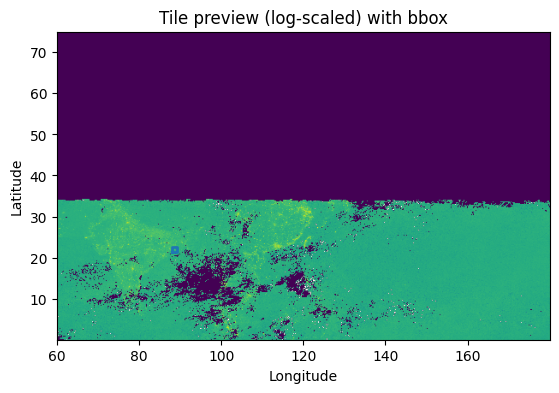

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

with rasterio.open(rad_path) as src:
    # pick a safe downsample size (never 0)
    rows = max(1, src.height // 50)
    cols = max(1, src.width // 50)

    # IMPORTANT: when you specify a single band (1), out_shape must be (rows, cols)
    preview = src.read(1, out_shape=(rows, cols)).astype("float64")

    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

plt.figure(figsize=(10, 4))
plt.imshow(np.log10(preview + 1e-6), extent=extent, origin="upper")
plt.title("Tile preview (log-scaled) with bbox")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Draw bbox rectangle
plt.plot(
    [bbox["lon_min"], bbox["lon_max"], bbox["lon_max"], bbox["lon_min"], bbox["lon_min"]],
    [bbox["lat_min"], bbox["lat_min"], bbox["lat_max"], bbox["lat_max"], bbox["lat_min"]],
    linewidth=2
)

plt.show()


**Data presence check (sampled)**

Compute a sampled fraction of pixels that are > 0 and the fraction that are NaN.
This gives a quick numeric sanity check that complements the preview plot.

In [27]:
import rasterio
import numpy as np

def fraction_nonzero(path, sample_step=50):
    with rasterio.open(path) as src:
        arr = src.read(1)[::sample_step, ::sample_step].astype("float64")
        nodata = src.nodata
        if nodata is not None:
            arr[arr == nodata] = np.nan
        valid = arr[~np.isnan(arr)]
        return float(np.mean(valid > 0)), float(np.mean(np.isnan(arr)))

rad_path = str(rad_path)  # if rad_path is a Path object
nz_frac, nan_frac = fraction_nonzero(rad_path, sample_step=50)

print("Fraction > 0 (sampled):", nz_frac)
print("Fraction NaN (sampled):", nan_frac)


Fraction > 0 (sampled): 0.4158854166666667
Fraction NaN (sampled): 0.0


**True bbox clip at full resolution (the “real” data we analyze)**

Here we clip the raster using from_bounds(...) and compute the true geographic extent from the window transform, so the plot axes are correct.

This is the step that corrected the earlier “looks empty” issue—because plotting the wrong slice / wrong extent can make valid data look unusable.

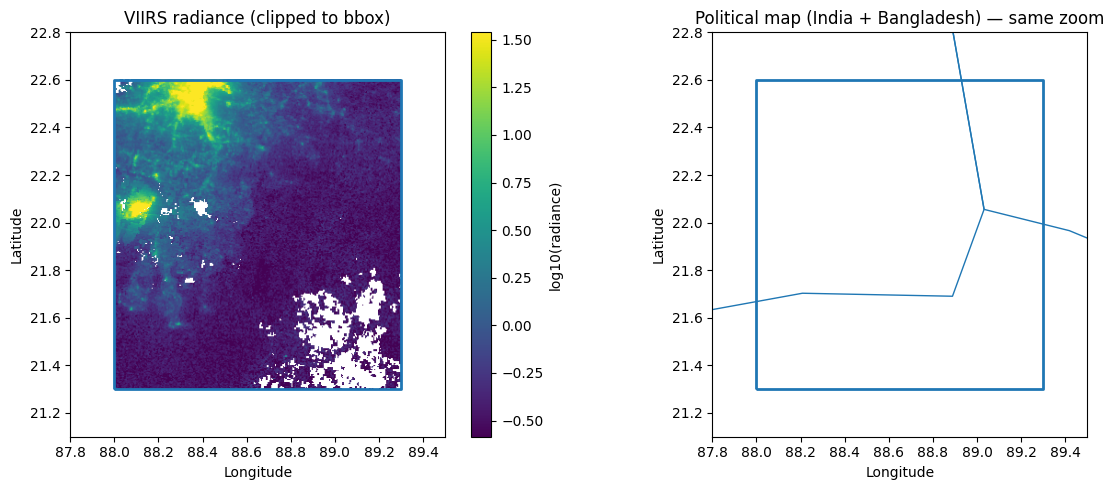

Clipped rad shape: (312, 312)
Coverage stats: min/median/max: 0.0 4.0 10.0
Valid radiance pixels after mask: 90823


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import from_bounds
import geopandas as gpd
from shapely.geometry import box

pad_lon, pad_lat = 0.2, 0.2
xlim = (bbox["lon_min"] - pad_lon, bbox["lon_max"] + pad_lon)
ylim = (bbox["lat_min"] - pad_lat, bbox["lat_max"] + pad_lat)

rad_path = str(rad_path)  # keep if Path
cvg_path = str(cvg_path)  # keep if Path (optional but recommended)

# ---- Read TRUE clipped window (full-res) ----
with rasterio.open(rad_path) as rsrc, rasterio.open(cvg_path) as csrc:
    window = from_bounds(
        bbox["lon_min"], bbox["lat_min"],
        bbox["lon_max"], bbox["lat_max"],
        transform=rsrc.transform
    )

    rad = rsrc.read(1, window=window).astype("float64")
    cvg = csrc.read(1, window=window).astype("float64")

    # extent of the clipped window in lon/lat for imshow
    transform = rsrc.window_transform(window)
    left = transform.c
    top = transform.f
    right = left + transform.a * rad.shape[1]
    bottom = top + transform.e * rad.shape[0]  # transform.e is negative in north-up rasters
    extent_clip = [left, right, bottom, top]

# Optional: mask low coverage just for visualization sanity
rad[cvg < 2] = np.nan

# Log scale
rad_log = np.log10(rad + 1e-6)

# Robust scaling: if everything is super dim, percentiles may be too tight.
valid = rad_log[~np.isnan(rad_log)]
if valid.size > 0:
    vmin = np.percentile(valid, 5)
    vmax = np.percentile(valid, 99)
else:
    vmin, vmax = -2.0, 0.5  # fallback

# ---- Political boundaries ----
countries_path = "../data/basemaps/natural_earth/ne_110m_admin_0_countries.shp"
countries = gpd.read_file(countries_path).to_crs("EPSG:4326")
region = countries[countries["NAME"].isin(["India", "Bangladesh"])]

bbox_poly = gpd.GeoDataFrame(
    geometry=[box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])],
    crs="EPSG:4326",
)

# ---- Plot side-by-side ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: TRUE clipped VIIRS
ax = axes[0]
cmap = plt.cm.viridis.copy()
cmap.set_bad(color="white")  # show masked as white
im = ax.imshow(rad_log, extent=extent_clip, origin="upper", vmin=vmin, vmax=vmax, cmap=cmap)
ax.set_title("VIIRS radiance (clipped to bbox)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
bbox_poly.boundary.plot(ax=ax, linewidth=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="log10(radiance)")

# Right: Political map
ax = axes[1]
region.boundary.plot(ax=ax, linewidth=1)
bbox_poly.boundary.plot(ax=ax, linewidth=2)
ax.set_title("Political map (India + Bangladesh) — same zoom")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.tight_layout()
plt.show()

print("Clipped rad shape:", rad.shape)
print("Coverage stats: min/median/max:", float(np.min(cvg)), float(np.median(cvg)), float(np.max(cvg)))
print("Valid radiance pixels after mask:", int(np.sum(~np.isnan(rad))))


**Bounding Box Stats**

Pixel statistics for the bounding box

In [30]:
import numpy as np
import rasterio
from rasterio.windows import from_bounds

def bbox_stats(rad_path, cvg_path, bbox, covg_min=2):
    with rasterio.open(rad_path) as rsrc, rasterio.open(cvg_path) as csrc:
        window = from_bounds(
            bbox["lon_min"], bbox["lat_min"],
            bbox["lon_max"], bbox["lat_max"],
            transform=rsrc.transform
        )
        rad = rsrc.read(1, window=window).astype("float64")
        cvg = csrc.read(1, window=window).astype("float64")

    # mask low coverage
    rad_masked = rad.copy()
    rad_masked[cvg < covg_min] = np.nan

    valid = rad_masked[np.isfinite(rad_masked)]
    print("shape:", rad.shape)
    print("coverage min/med/max:", float(np.min(cvg)), float(np.median(cvg)), float(np.max(cvg)))
    print("valid fraction after mask:", float(np.mean(np.isfinite(rad_masked))))

    if valid.size == 0:
        print("NO valid pixels after mask")
        return

    p = np.percentile(valid, [0, 1, 5, 50, 95, 99, 100])
    print("radiance percentiles [min,1,5,50,95,99,max]:", p)
    print("mean radiance:", float(np.mean(valid)))
    print("fraction > 0 (valid):", float(np.mean(valid > 0)))

# Example:
# bbox_stats(june_rad_path, june_cvg_path, bbox)
# bbox_stats(jan_rad_path, jan_cvg_path, bbox)

bbox_stats(rad_path, cvg_path, bbox)

shape: (312, 312)
coverage min/med/max: 0.0 4.0 10.0
valid fraction after mask: 0.9330107659434582
radiance percentiles [min,1,5,50,95,99,max]: [2.99999993e-02 2.00000003e-01 2.59999990e-01 4.49999988e-01
 4.71000004e+00 3.46045990e+01 1.70944995e+03]
mean radiance: 1.8817008887556919
fraction > 0 (valid): 1.0


**Checking for outlier-like values**

To investigate why the top half of June data is missing, let's find out pixel values greater than 1000

In [31]:
import numpy as np

# rad_masked: radiance array with low coverage already set to np.nan
rad_masked = rad.copy(); rad_masked[cvg < 2] = np.nan

thr = 1000.0
vals = rad_masked[np.isfinite(rad_masked)]

count_total = vals.size
count_ge = int(np.sum(vals >= thr))
frac_ge = count_ge / count_total if count_total else 0.0

print(f"Total valid pixels: {count_total}")
print(f"Pixels >= {thr}: {count_ge} ({frac_ge:.6%})")


Total valid pixels: 90823
Pixels >= 1000.0: 7 (0.007707%)


**Coastline / island outlines (Natural Earth 10m land polygons)**

Instead of country borders, we overlay land polygon boundaries clipped to the bbox.
This is the right layer to “draw the islands” because it captures coastline geometry at higher detail.

White masked regions correspond to low-coverage pixels (or masked radiance), not necessarily “no land.”

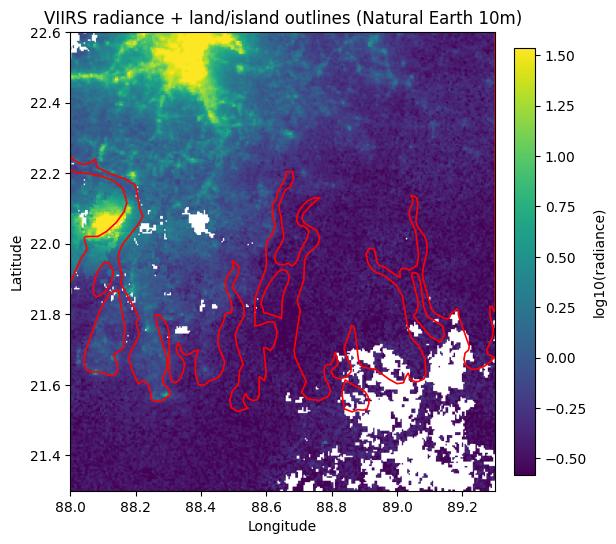

In [33]:
import geopandas as gpd
from shapely.geometry import box

# Load Natural Earth land polygons (10m)
land_path = "../data/basemaps/natural_earth/ne_10m_land.shp"
land = gpd.read_file(land_path).to_crs("EPSG:4326")

# Clip land to your bbox (fast + clean)
bbox_geom = box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])
land_clip = land[land.intersects(bbox_geom)].copy()
land_clip["geometry"] = land_clip.intersection(bbox_geom)

# Plot VIIRS
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

cmap = plt.cm.viridis.copy()
cmap.set_bad(color="white")

im = ax.imshow(rad_log, extent=extent_clip, origin="upper", vmin=vmin, vmax=vmax, cmap=cmap)

# Overlay coastline / islands
land_clip.boundary.plot(ax=ax, linewidth=1.2, color="red")

ax.set_title("VIIRS radiance + land/island outlines (Natural Earth 10m)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="log10(radiance)")
plt.show()


**Feature extraction for a bbox (radiance + coverage → summary stats)**

We convert the clipped window into a compact row of features:

- valid pixel fraction after coverage mask

- radiance summary stats (mean, p50, p95, p99, max)

- “lit fraction” above a high percentile threshold (default p90)

- log-space summary stats (more stable for skewed values)

- coverage min/median/max and low-coverage fraction

This makes month-to-month comparison straightforward and reproducible.

In [34]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import from_bounds

def extract_viirs_bbox_features(
    rad_path: str,
    cvg_path: str,
    bbox: dict,
    month_label: str,
    covg_threshold: float = 2.0,
    eps: float = 1e-6,
    lit_percentile: float = 90.0,
) -> pd.DataFrame:
    """
    Extract summary features from VIIRS DNB monthly composite for a lon/lat bbox.
    - rad_path: *.avg_rade9h.tif
    - cvg_path: *.cf_cvg.tif
    - bbox: {"lon_min":..., "lat_min":..., "lon_max":..., "lat_max":...}
    - month_label: string like "2018-06"
    """

    with rasterio.open(rad_path) as rsrc, rasterio.open(cvg_path) as csrc:
        if rsrc.crs is None or str(rsrc.crs).upper() != "EPSG:4326":
            raise ValueError(f"Expected rad CRS EPSG:4326, got: {rsrc.crs}")
        if csrc.crs is None or str(csrc.crs).upper() != "EPSG:4326":
            raise ValueError(f"Expected cvg CRS EPSG:4326, got: {csrc.crs}")

        window = from_bounds(
            bbox["lon_min"], bbox["lat_min"],
            bbox["lon_max"], bbox["lat_max"],
            transform=rsrc.transform
        )

        rad = rsrc.read(1, window=window).astype("float64")
        cvg = csrc.read(1, window=window).astype("float64")

        # Handle nodata if present
        if rsrc.nodata is not None:
            rad[rad == rsrc.nodata] = np.nan
        if csrc.nodata is not None:
            cvg[cvg == csrc.nodata] = np.nan

        # Basic sanity: if window is empty
        if rad.size == 0 or cvg.size == 0 or rad.shape[0] == 0 or rad.shape[1] == 0:
            raise ValueError(f"Empty clip window. rad shape={rad.shape}, cvg shape={cvg.shape}")

        # Coverage quality fractions
        low_cvg_mask = (cvg < covg_threshold) | np.isnan(cvg)
        low_cvg_frac = float(np.mean(low_cvg_mask))

        # Apply coverage mask to radiance for "reliable" stats
        rad_masked = rad.copy()
        rad_masked[low_cvg_mask] = np.nan

        # Radiance can have tiny negatives in some products; guard before log
        rad_masked = np.where(rad_masked < 0, 0.0, rad_masked)

        valid_mask = ~np.isnan(rad_masked)
        valid_pixels = int(np.sum(valid_mask))
        total_pixels = int(rad_masked.size)
        valid_frac = float(valid_pixels / total_pixels)

        # If everything got masked, return a row with NaNs but still track coverage
        if valid_pixels == 0:
            row = {
                "month": month_label,
                "lon_min": bbox["lon_min"], "lat_min": bbox["lat_min"],
                "lon_max": bbox["lon_max"], "lat_max": bbox["lat_max"],
                "shape_rows": rad.shape[0], "shape_cols": rad.shape[1],
                "total_pixels": total_pixels,
                "valid_pixels": valid_pixels,
                "valid_frac": valid_frac,
                "low_cvg_frac": low_cvg_frac,
                "rad_mean": np.nan,
                "rad_p50": np.nan,
                "rad_p95": np.nan,
                "rad_p99": np.nan,
                "rad_max": np.nan,
                "lit_threshold_rad": np.nan,
                "lit_frac": np.nan,
                "log_rad_mean": np.nan,
                "log_rad_p50": np.nan,
                "log_rad_p95": np.nan,
                "log_rad_p99": np.nan,
                "cvg_min": float(np.nanmin(cvg)),
                "cvg_median": float(np.nanmedian(cvg)),
                "cvg_max": float(np.nanmax(cvg)),
            }
            return pd.DataFrame([row])

        vals = rad_masked[valid_mask]

        # Radiance stats (linear space)
        rad_mean = float(np.mean(vals))
        rad_p50, rad_p95, rad_p99 = [float(x) for x in np.percentile(vals, [50, 95, 99])]
        rad_max = float(np.max(vals))

        # "Lit fraction": fraction of valid pixels above a high percentile threshold
        lit_threshold = float(np.percentile(vals, lit_percentile))
        lit_frac = float(np.mean(vals > lit_threshold))

        # Log-radiance stats (use eps)
        log_vals = np.log10(vals + eps)
        log_mean = float(np.mean(log_vals))
        log_p50, log_p95, log_p99 = [float(x) for x in np.percentile(log_vals, [50, 95, 99])]

        # Coverage stats
        cvg_min = float(np.nanmin(cvg))
        cvg_median = float(np.nanmedian(cvg))
        cvg_max = float(np.nanmax(cvg))

        row = {
            "month": month_label,
            "lon_min": bbox["lon_min"], "lat_min": bbox["lat_min"],
            "lon_max": bbox["lon_max"], "lat_max": bbox["lat_max"],
            "shape_rows": rad.shape[0], "shape_cols": rad.shape[1],
            "total_pixels": total_pixels,
            "valid_pixels": valid_pixels,
            "valid_frac": valid_frac,
            "low_cvg_frac": low_cvg_frac,
            "rad_mean": rad_mean,
            "rad_p50": rad_p50,
            "rad_p95": rad_p95,
            "rad_p99": rad_p99,
            "rad_max": rad_max,
            "lit_threshold_rad": lit_threshold,
            "lit_frac": lit_frac,
            "log_rad_mean": log_mean,
            "log_rad_p50": log_p50,
            "log_rad_p95": log_p95,
            "log_rad_p99": log_p99,
            "cvg_min": cvg_min,
            "cvg_median": cvg_median,
            "cvg_max": cvg_max,
        }

        return pd.DataFrame([row])


# ---- Example usage (June 2018) ----
# Update these if needed
month_label = "2018-06"
df = extract_viirs_bbox_features(
    rad_path=str(rad_path),
    cvg_path=str(cvg_path),
    bbox=bbox,
    month_label=month_label,
    covg_threshold=2.0,
    lit_percentile=90.0,
)

display(df)

# ---- Append/save ----
out_csv = "../data/ntl/ceam_bbox_features.csv"
import os
os.makedirs(os.path.dirname(out_csv), exist_ok=True)

if os.path.exists(out_csv):
    old = pd.read_csv(out_csv)
    combined = pd.concat([old, df], ignore_index=True)
    combined.to_csv(out_csv, index=False)
else:
    df.to_csv(out_csv, index=False)

print(f"Saved/updated: {out_csv}")


,month,lon_min,lat_min,lon_max,lat_max,shape_rows,shape_cols,total_pixels,valid_pixels,valid_frac,...,rad_max,lit_threshold_rad,lit_frac,log_rad_mean,log_rad_p50,log_rad_p95,log_rad_p99,cvg_min,cvg_median,cvg_max
0,2018-06,88.0,21.3,89.3,22.6,312,312,97344,90823,0.933011,...,1709.449951,2.12,0.099776,-0.190263,-0.346787,0.673021,1.539134,0.0,4.0,10.0


Saved/updated: data/ntl/ceam_bbox_features.csv


## April 2019 Data

**Input files (April 2019):**

- avg_rade9h = average radiance (the “night lights” intensity)
- cf_cvg = coverage / observation count-type layer used as a reliability mask

In [35]:
rad_path = "../data/ntl/raw/201904/SVDNB_npp_20190401-20190430_75N060E_vcmcfg_v10_c201905191000.avg_rade9h.tif"
cvg_path = "../data/ntl/raw/201904/SVDNB_npp_20190401-20190430_75N060E_vcmcfg_v10_c201905191000.cf_cvg.tif"

**Guardrail sanity check (CRS, bounds, and a known point)**

This helper prints CRS, bounds, resolution, array shape, and optionally samples a known lon/lat point (near Sundarbans) to confirm the raster is:

in EPSG:4326, and

actually contains our region of interest.

This is the “don’t-trust-the-plot-yet” check that prevents false conclusions.

In [36]:
raster_guardrail(str(rad_path), target_lon=88.9, target_lat=22.0, name="VIIRS radiance")
raster_guardrail(str(cvg_path), target_lon=88.9, target_lat=22.0, name="VIIRS coverage")


[VIIRS radiance] ../data/ntl/raw/201904/SVDNB_npp_20190401-20190430_75N060E_vcmcfg_v10_c201905191000.avg_rade9h.tif
CRS: EPSG:4326
Bounds: BoundingBox(left=59.99791666665, bottom=0.0020827333499937595, right=179.99791762665, top=75.00208333335)
Res: (0.0041666667, 0.0041666667)
Shape: (18000, 28800)
NoData: None
Target point -> row,col=(12720,6936), value=0.25999999046325684

[VIIRS coverage] ../data/ntl/raw/201904/SVDNB_npp_20190401-20190430_75N060E_vcmcfg_v10_c201905191000.cf_cvg.tif
CRS: EPSG:4326
Bounds: BoundingBox(left=59.99791666665, bottom=0.0020827333499937595, right=179.99791762665, top=75.00208333335)
Res: (0.0041666667, 0.0041666667)
Shape: (18000, 28800)
NoData: None
Target point -> row,col=(12720,6936), value=11


**Quick visual smoke test (downsampled)**

This is a fast sanity plot (heavily downsampled) just to confirm the raster has structure and is not empty/corrupt—not for interpretation.

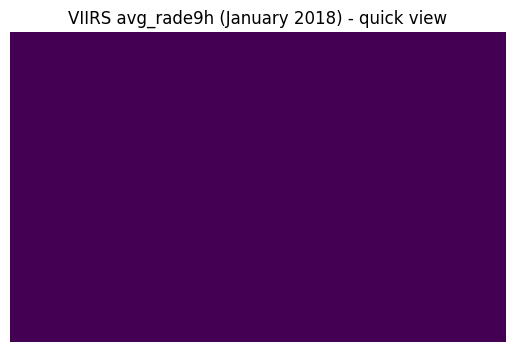

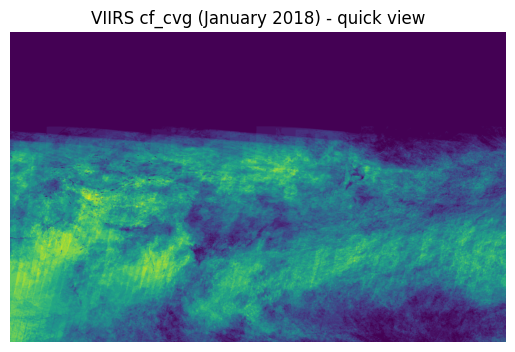

In [37]:
import matplotlib.pyplot as plt

def show_quick(path, title):
    with rasterio.open(path) as src:
        arr = src.read(1)
        # simple downsample to avoid huge plots
        arr_small = arr[::10, ::10]

    plt.figure()
    plt.imshow(arr_small)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_quick(rad_path, "VIIRS avg_rade9h (January 2018) - quick view")
show_quick(cvg_path, "VIIRS cf_cvg (January 2018) - quick view")

**First-pass radiance visibility: mask low coverage, then log-scale**

Mask pixels where coverage is low (cvg < 2) to avoid interpreting unreliable values.

Apply log10(radiance) because VIIRS radiance is highly skewed (a few bright areas dominate).

Note: warnings like “invalid value encountered in log10” typically happen when there are NaNs (from masking) or zeros—expected in this workflow.

/var/folders/53/ps9kkpj52j71m9fx4fmfqxsw0000gn/T/ipykernel_73310/496708119.py:13: RuntimeWarning: invalid value encountered in log10
  rad_log = np.log10(rad + 1e-6)


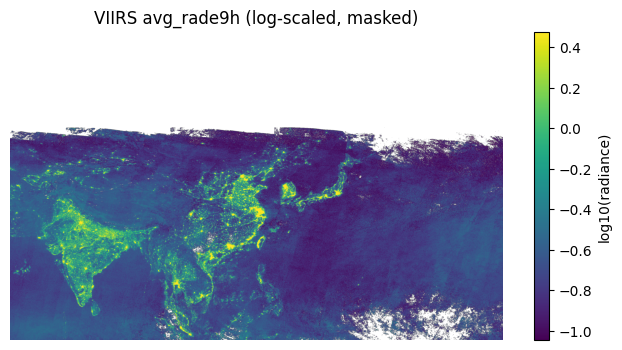

In [38]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

with rasterio.open(rad_path) as rsrc, rasterio.open(cvg_path) as csrc:
    rad = rsrc.read(1).astype("float64")
    cvg = csrc.read(1).astype("float64")

# Mask low observation coverage (tunable)
rad[cvg < 2] = np.nan

# Log transform for visibility
rad_log = np.log10(rad + 1e-6)

# Percentile stretch (ignore extreme outliers)
vmin, vmax = np.nanpercentile(rad_log, [5, 99])

plt.figure(figsize=(8, 4))
plt.imshow(rad_log[::10, ::10], vmin=vmin, vmax=vmax)
plt.title("VIIRS avg_rade9h (log-scaled, masked)")
plt.colorbar(label="log10(radiance)")
plt.axis("off")
plt.show()

**Tile-scale context view (downsampled) + bbox overlay**

Before zooming in, we plot a coarse preview of the entire VIIRS tile and draw the bbox rectangle on top.

This is a key guardrail: if the bbox is drawn in the wrong place (or axes look wrong), we fix that before doing any “region-level” interpretation.

/var/folders/53/ps9kkpj52j71m9fx4fmfqxsw0000gn/T/ipykernel_73310/2753919968.py:16: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(preview + 1e-6), extent=extent, origin="upper")


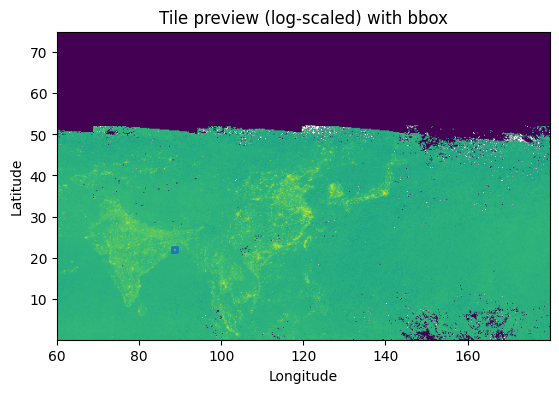

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

with rasterio.open(rad_path) as src:
    # pick a safe downsample size (never 0)
    rows = max(1, src.height // 50)
    cols = max(1, src.width // 50)

    # IMPORTANT: when you specify a single band (1), out_shape must be (rows, cols)
    preview = src.read(1, out_shape=(rows, cols)).astype("float64")

    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

plt.figure(figsize=(10, 4))
plt.imshow(np.log10(preview + 1e-6), extent=extent, origin="upper")
plt.title("Tile preview (log-scaled) with bbox")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Draw bbox rectangle
plt.plot(
    [bbox["lon_min"], bbox["lon_max"], bbox["lon_max"], bbox["lon_min"], bbox["lon_min"]],
    [bbox["lat_min"], bbox["lat_min"], bbox["lat_max"], bbox["lat_max"], bbox["lat_min"]],
    linewidth=2
)

plt.show()

**Data presence check (sampled)**

Compute a sampled fraction of pixels that are > 0 and the fraction that are NaN.
This gives a quick numeric sanity check that complements the preview plot.

In [40]:
import rasterio
import numpy as np

def fraction_nonzero(path, sample_step=50):
    with rasterio.open(path) as src:
        arr = src.read(1)[::sample_step, ::sample_step].astype("float64")
        nodata = src.nodata
        if nodata is not None:
            arr[arr == nodata] = np.nan
        valid = arr[~np.isnan(arr)]
        return float(np.mean(valid > 0)), float(np.mean(np.isnan(arr)))

rad_path = str(rad_path)  # if rad_path is a Path object
nz_frac, nan_frac = fraction_nonzero(rad_path, sample_step=50)

print("Fraction > 0 (sampled):", nz_frac)
print("Fraction NaN (sampled):", nan_frac)

Fraction > 0 (sampled): 0.6646170910493827
Fraction NaN (sampled): 0.0


**True bbox clip at full resolution (the “real” data we analyze)**

Here we clip the raster using from_bounds(...) and compute the true geographic extent from the window transform, so the plot axes are correct.

This is the step that corrected the earlier “looks empty” issue—because plotting the wrong slice / wrong extent can make valid data look unusable.

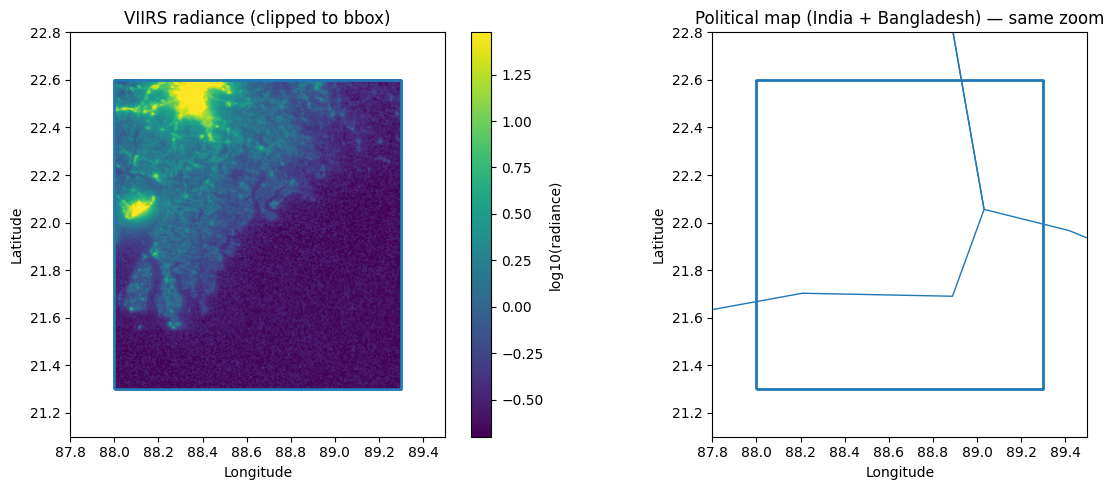

Clipped rad shape: (312, 312)
Coverage stats: min/median/max: 5.0 10.0 14.0
Valid radiance pixels after mask: 97344


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import from_bounds
import geopandas as gpd
from shapely.geometry import box

pad_lon, pad_lat = 0.2, 0.2
xlim = (bbox["lon_min"] - pad_lon, bbox["lon_max"] + pad_lon)
ylim = (bbox["lat_min"] - pad_lat, bbox["lat_max"] + pad_lat)

rad_path = str(rad_path)  # keep if Path
cvg_path = str(cvg_path)  # keep if Path (optional but recommended)

# ---- Read TRUE clipped window (full-res) ----
with rasterio.open(rad_path) as rsrc, rasterio.open(cvg_path) as csrc:
    window = from_bounds(
        bbox["lon_min"], bbox["lat_min"],
        bbox["lon_max"], bbox["lat_max"],
        transform=rsrc.transform
    )

    rad = rsrc.read(1, window=window).astype("float64")
    cvg = csrc.read(1, window=window).astype("float64")

    # extent of the clipped window in lon/lat for imshow
    transform = rsrc.window_transform(window)
    left = transform.c
    top = transform.f
    right = left + transform.a * rad.shape[1]
    bottom = top + transform.e * rad.shape[0]  # transform.e is negative in north-up rasters
    extent_clip = [left, right, bottom, top]

# Optional: mask low coverage just for visualization sanity
rad[cvg < 2] = np.nan

# Log scale
rad_log = np.log10(rad + 1e-6)

# Robust scaling: if everything is super dim, percentiles may be too tight.
valid = rad_log[~np.isnan(rad_log)]
if valid.size > 0:
    vmin = np.percentile(valid, 5)
    vmax = np.percentile(valid, 99)
else:
    vmin, vmax = -2.0, 0.5  # fallback

# ---- Political boundaries ----
countries_path = "../data/basemaps/natural_earth/ne_110m_admin_0_countries.shp"
countries = gpd.read_file(countries_path).to_crs("EPSG:4326")
region = countries[countries["NAME"].isin(["India", "Bangladesh"])]

bbox_poly = gpd.GeoDataFrame(
    geometry=[box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])],
    crs="EPSG:4326",
)

# ---- Plot side-by-side ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: TRUE clipped VIIRS
ax = axes[0]
cmap = plt.cm.viridis.copy()
cmap.set_bad(color="white")  # show masked as white
im = ax.imshow(rad_log, extent=extent_clip, origin="upper", vmin=vmin, vmax=vmax, cmap=cmap)
ax.set_title("VIIRS radiance (clipped to bbox)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
bbox_poly.boundary.plot(ax=ax, linewidth=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="log10(radiance)")

# Right: Political map
ax = axes[1]
region.boundary.plot(ax=ax, linewidth=1)
bbox_poly.boundary.plot(ax=ax, linewidth=2)
ax.set_title("Political map (India + Bangladesh) — same zoom")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.tight_layout()
plt.show()

print("Clipped rad shape:", rad.shape)
print("Coverage stats: min/median/max:", float(np.min(cvg)), float(np.median(cvg)), float(np.max(cvg)))
print("Valid radiance pixels after mask:", int(np.sum(~np.isnan(rad))))


**Checking for outlier-like values**

To investigate why the top half of June data is missing, let's find out pixel values greater than 1000

In [43]:
bbox_stats(rad_path, cvg_path, bbox)

shape: (312, 312)
coverage min/med/max: 5.0 10.0 14.0
valid fraction after mask: 1.0
radiance percentiles [min,1,5,50,95,99,max]: [9.00000036e-02 1.59999996e-01 2.00000003e-01 3.40000004e-01
 3.74000001e+00 3.00100002e+01 3.39820007e+02]
mean radiance: 1.4697968039501985
fraction > 0 (valid): 1.0


**Coastline / island outlines (Natural Earth 10m land polygons)**

Instead of country borders, we overlay land polygon boundaries clipped to the bbox.
This is the right layer to “draw the islands” because it captures coastline geometry at higher detail.

White masked regions correspond to low-coverage pixels (or masked radiance), not necessarily “no land.”"

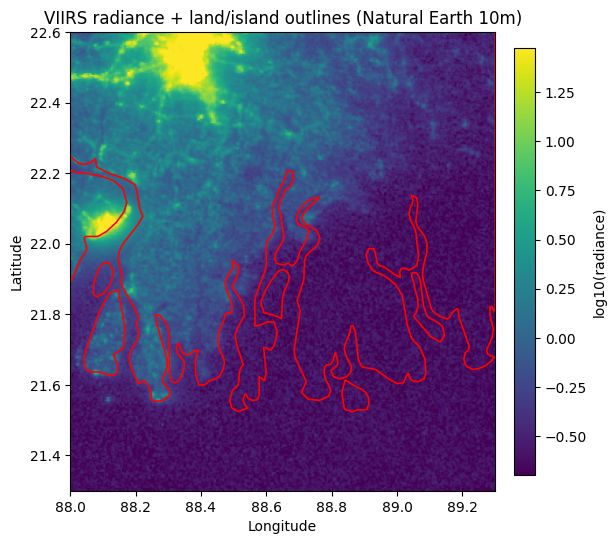

In [46]:
import geopandas as gpd
from shapely.geometry import box

# Load Natural Earth land polygons (10m)
land_path = "../data/basemaps/natural_earth/ne_10m_land.shp"
land = gpd.read_file(land_path).to_crs("EPSG:4326")

# Clip land to your bbox (fast + clean)
bbox_geom = box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])
land_clip = land[land.intersects(bbox_geom)].copy()
land_clip["geometry"] = land_clip.intersection(bbox_geom)

# Plot VIIRS
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

cmap = plt.cm.viridis.copy()
cmap.set_bad(color="white")

im = ax.imshow(rad_log, extent=extent_clip, origin="upper", vmin=vmin, vmax=vmax, cmap=cmap)

# Overlay coastline / islands
land_clip.boundary.plot(ax=ax, linewidth=1.2, color="red")

ax.set_title("VIIRS radiance + land/island outlines (Natural Earth 10m)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="log10(radiance)")
plt.show()


**Feature extraction for a bbox (radiance + coverage → summary stats)**

We convert the clipped window into a compact row of features:

- valid pixel fraction after coverage mask

- radiance summary stats (mean, p50, p95, p99, max)

- “lit fraction” above a high percentile threshold (default p90)

- log-space summary stats (more stable for skewed values)

- coverage min/median/max and low-coverage fraction

This makes month-to-month comparison straightforward and reproducible.

In [48]:
# ---- Example usage (April 2019) ----
# Update these if needed
month_label = "2019-04"
df = extract_viirs_bbox_features(
    rad_path=str(rad_path),
    cvg_path=str(cvg_path),
    bbox=bbox,
    month_label=month_label,
    covg_threshold=2.0,
    lit_percentile=90.0,
)

display(df)

# ---- Append/save ----
out_csv = "../data/ntl/ceam_bbox_features.csv"
import os
os.makedirs(os.path.dirname(out_csv), exist_ok=True)

if os.path.exists(out_csv):
    old = pd.read_csv(out_csv)
    combined = pd.concat([old, df], ignore_index=True)
    combined.to_csv(out_csv, index=False)
else:
    df.to_csv(out_csv, index=False)

print(f"Saved/updated: {out_csv}")


,month,lon_min,lat_min,lon_max,lat_max,shape_rows,shape_cols,total_pixels,valid_pixels,valid_frac,...,rad_max,lit_threshold_rad,lit_frac,log_rad_mean,log_rad_p50,log_rad_p95,log_rad_p99,cvg_min,cvg_median,cvg_max
0,2019-04,88.0,21.3,89.3,22.6,312,312,97344,97344,1.0,...,339.820007,1.94,0.099657,-0.270885,-0.46852,0.572872,1.477266,5.0,10.0,14.0


Saved/updated: ../data/ntl/ceam_bbox_features.csv
